## Training multi-fidelity neural networks for small/large amplitude oscillatory shear (S/LAOS) rheometry
The output of this notebook is the model's stored training, which is used to predict the oscillatory shear stress.

### Importing the dependencies

In [1]:
from time import time
from datetime import datetime
import os
import sys
import math
import tensorflow as tf
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
import itertools

### Loading the Lo-Fi and Hi-Fi data
We generated the Lo-Fi data using a Maxwell model with inputs being the time, maximum strain, and angular frequency. However, and as stated in the manuscript, the same set of inputs fails to yield accurate stress predictions for MFNN training. Therefore, the inputs here are the strain, strain rate, and angular frequency, with the output being the shear stress.

If the input data is noisy, one can use the `moving_average_filter()` function below to smoothen the data.

In [24]:
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
SEED=42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

log10 = tf.experimental.numpy.log10
path = os.getcwd()
files = os.listdir(path)
df = {}
Shuffle = False

url_lf = 'https://github.com/procf/RhINNs/raw/main/MFNN/SAOS/Data_LF_SAOS.xlsx'
url_hf = 'https://github.com/procf/RhINNs/raw/main/MFNN/SAOS/Data_HF_SAOS.xlsx'
url_hf_raw = 'https://github.com/procf/RhINNs/raw/main/MFNN/SAOS/Data_HF_SAOS_raw.xlsx'

#Uncomment to run locally
# url_lf, url_hf = 'Data_LF_SAOS.xlsx', 'Data_HF_SAOS.xlsx'

df_LF = pd.read_excel(url_lf, sheet_name=None)
data_LF = [[k,v] for k,v in df_LF.items()] #k is the sheet name, v is the pandas df

df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k,v] for k,v in df_HF.items()] #k is the sheet name, v is the pandas df

sample=0
data_HF[sample][1] = data_HF[sample][1].dropna()
# data_HF[sample][1] = data_HF[sample][1].iloc[::20]
# data_LF[sample][1] = data_LF[sample][1].iloc[::20]

#LF
x1_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['Strain'], dtype=DTYPE),(-1,1))
x2_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['StrainRate'], dtype=DTYPE), (-1,1))
x3_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['AngFreq'], dtype=DTYPE), (-1,1))
x4_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['Time'], dtype=DTYPE), (-1,1))
x5_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['G0'], dtype=DTYPE), (-1,1))

y1_d_LF = tf.reshape(tf.convert_to_tensor(data_LF[sample][1]['Stress'], dtype=DTYPE), (-1,1))

#HF
x1_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['Strain'], dtype=DTYPE),(-1,1))
x2_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['StrainRate'], dtype=DTYPE), (-1,1))
x3_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['AngFreq'], dtype=DTYPE), (-1,1))
x4_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['Time'], dtype=DTYPE), (-1,1))
x5_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['G0'], dtype=DTYPE), (-1,1))

y1_d_HF = tf.reshape(tf.convert_to_tensor(data_HF[sample][1]['Stress'], dtype=DTYPE), (-1,1))

def moving_average_filter(data, window_size):
    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, window, mode='same')
    return smoothed_data

# Example data
window_size = 2

# Applying moving average filter
# y1_d_HF = moving_average_filter(np.reshape(y1_d_HF, (-1,)), window_size)
y1_d_HF = tf.reshape(tf.convert_to_tensor(y1_d_HF, dtype=DTYPE), (-1,1))

x1min, x1max = np.min(x1_d_HF), np.max(x1_d_HF)
x2min, x2max = np.min(x2_d_HF), np.max(x2_d_HF)
x3min, x3max = np.min(x3_d_HF), np.max(x3_d_HF)

lb = tf.constant([x1min, x2min, x3min], dtype=DTYPE).numpy()
ub = tf.constant([x1max, x2max, x3max], dtype=DTYPE).numpy()

X_data_HF = tf.concat([x1_d_HF, x2_d_HF, x3_d_HF], axis=1)
y_data_HF = tf.concat([y1_d_HF], axis=1)  

X_data_LF = tf.concat([x1_d_LF, x2_d_LF, x3_d_LF], axis=1)
y_data_LF = tf.concat([y1_d_LF], axis=1)  


if Shuffle:
    X_data_HF = X_data_HF.numpy()
    X_data_LF = X_data_LF.numpy()
    y_data_HF = y_data_HF.numpy()
    y_data_LF = y_data_LF.numpy()

    # Get the number of samples
    num_samples_HF = X_data_HF.shape[0]
    num_samples_LF = X_data_LF.shape[0]

    # Create shuffled indices for both HF and LF data
    shuffled_indices_HF = np.random.permutation(num_samples_HF)
    shuffled_indices_LF = np.random.permutation(num_samples_LF)

    # Shuffle the data using the shuffled indices
    X_data_HF = X_data_HF[shuffled_indices_HF]
    y_data_HF = y_data_HF[shuffled_indices_HF]

    X_data_LF = X_data_LF[shuffled_indices_LF]
    y_data_LF = y_data_LF[shuffled_indices_LF]

in_dim, out_dim = 3, 1

### Data normalization
In this case, it is important to normalize the data between -1 and 1.

In [25]:
def normalize_data(X_data, y_data, x1_scale, x2_scale, x3_scale, y1_scale):
    # Normalize the input features
    X_data_normalized = X_data / tf.constant([x1_scale, x2_scale, x3_scale], dtype=tf.float32)
    
    # Normalize the output target
    y_data_normalized = y_data / tf.constant([y1_scale], dtype=tf.float32)
    
    return X_data_normalized, y_data_normalized
norm = [1000., 100., 10., 217.]
# Normalize the HF dataset
X_data_HF, y_data_HF = normalize_data(X_data_HF, y_data_HF, *norm)

# Normalize the LF dataset
X_data_LF, y_data_LF = normalize_data(X_data_LF, y_data_LF, *norm)


### Defining the NN
Here, `PINN_NeuralNet` is a `tf.keras.Model` instance with several fully-connected layers.

In [6]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
            output_dim=out_dim,
            num_hidden_layers=4, 
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lambd_list = []
    
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    
    def call(self, X):
        """Forward-pass through neural network."""
        Z = X
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

### Modifying the NN training procedure
The functions `update_last_n_losses()` and `ES()` are defined to provide early stopping of training once the relative error in the last 200 iterations is not changing below a threshold, i.e., $1\times10^{-4}$.

The function `loss_fn()` provides the MFNN architecture and error heuristics; see the above image and follow along the `loss_fn()` lines. L2 norms are necessary to control overfitting and regularize the model.

The function `get_grad()` records the trainable variables of all three NNs, calculates the loss (`loss_frac` is just a sanity check to track loss components), takes the gradient of the loss w.r.t. the trainable variables, and return those gradients.

The function `train_step()` calls the `get_grad()` function, applies the optimizer to those gradients, and returns the loss.

Finally, a `for` loop with call the `train_step()` function for a set number of iterations (`N`). Note that the `max_relative_error` variable will terminate the training loop once the early stopping procedure is triggered.

The `callback()` is responsible for printing the loss values, while `plot_loss_history()` provides the loss history w.r.t. iterations.

In this cell, it is also possible to use the `L-BFGS` optimizer. Actually, the current version uses the Adam optimizer for a set number of iterations, then use the trained weights to start an `L-BFGS` session. Two things: `L-BFGS` accepts float64 variables, and they should be flattened.

In [26]:
class PINNSolver():
    def __init__(self, model_LF, model_HF_nl, model_HF_l):
        self.model_LF = model_LF
        self.model_HF_nl = model_HF_nl
        self.model_HF_l = model_HF_l
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        self.last_n_losses = []
        
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 200:
            self.last_n_losses.pop(0)
            
    def ES(self):
        if len(self.last_n_losses) < 200:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    def loss_fn(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF):        
        y_pred_LF = self.model_LF(X_data_LF)
        y_pred_LF_HF = self.model_LF(X_data_HF)
        y_pred_HF_nl = self.model_HF_nl(tf.concat([X_data_HF, y_pred_LF_HF], axis=1))
        y_pred_HF_l = self.model_HF_l(tf.concat([X_data_HF, y_pred_LF_HF], axis=1))
        y_pred_HF = y_pred_HF_nl + y_pred_HF_l
        
        Loss_L2 = 1e-6*tf.add_n([tf.nn.l2_loss(w_) for w_ in self.model_HF_nl.trainable_weights])
        Loss_L2 += 1e-3*tf.add_n([tf.nn.l2_loss(w_) for w_ in self.model_LF.trainable_weights])
        Loss_data_LF = tf.reduce_mean(tf.square(y_data_LF - y_pred_LF))
        Loss_data_HF = tf.reduce_mean(tf.square(y_data_HF - y_pred_HF))
        loss = Loss_data_LF + Loss_data_HF + Loss_L2# 
        loss_frac = [Loss_data_LF, Loss_data_HF, Loss_L2]
        return loss, loss_frac
    
    def get_grad(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF):
        trainable_list = self.model_LF.trainable_variables + self.model_HF_nl.trainable_variables + self.model_HF_l.trainable_variables
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(trainable_list)
            loss, loss_frac = self.loss_fn(X_data_LF, X_data_HF, y_data_LF, y_data_HF)   
        g = tape.gradient(loss, trainable_list)
        del tape        
        return loss, g, loss_frac   
    
    def solve_with_TFoptimizer(self, optimizer, X_data_LF, X_data_HF, y_data_LF, y_data_HF, N=1001):
        @tf.function
        def train_step():
            loss, g, loss_frac = self.get_grad(X_data_LF, X_data_HF, y_data_LF, y_data_HF)
            trainable_list = self.model_LF.trainable_variables + self.model_HF_nl.trainable_variables + self.model_HF_l.trainable_variables
            optimizer.apply_gradients(zip(g, trainable_list))
            return loss, loss_frac
        
        for i in range(N):          
            loss, loss_frac = train_step()
            self.loss_frac = loss_frac
            self.current_loss = loss.numpy()
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            if self.max_relative_error < 1e-4: # in %
                tf.print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break
        
    def callback(self, xr=None):
        if self.iter % 5000 == 0:
            tf.print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                                     self.current_loss,
                                                                     np.round(self.max_relative_error, 2)))

        self.hist.append(self.current_loss)
        self.iter+=1
        
        
    def solve_with_ScipyOptimizer(self, X_data_LF, X_data_HF, y_data_LF, y_data_HF, method='L-BFGS-B', **kwargs):
        def get_weight_tensor():
            weight_list = []
            shape_list = []
            for v in self.model_LF.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
            for v in self.model_HF_nl.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
            for v in self.model_HF_l.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            idx = 0
            for v in self.model_LF.variables:
                vs = v.shape
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

            for v in self.model_HF_nl.variables:
                vs = v.shape
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

            for v in self.model_HF_l.variables:
                vs = v.shape
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            set_weight_tensor(w)
            loss, grad, loss_frac = self.get_grad(X_data_LF, X_data_HF, y_data_LF, y_data_HF)
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss   
            self.loss_frac = loss_frac
            self.max_relative_error = self.ES()
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
         
        return scipy.optimize.minimize(fun=get_loss_and_grad,x0=x0,jac=True,method=method,callback=self.callback,**kwargs)
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

### Instantiating the NNs and the solver
Here, the Lo-Fi, the nonlinear Hi-Fi, and the linear Hi-Fi NNs are instantiated from the `PINN_NeuralNet()` class. There are then built with their specified input shapes. We had `n=3`, which is `in_dim` in the below cell. We also have a 1-D output, which is the LAOS shear stress. Therefore, the Lo-Fi NN takes `in_dim=3`-D inputs and spits `out_dim=1`-D output. Then, the nonlinear Hi-Fi NN lifts the `out_dim=1`-D Lo-Fi output + its own inputs, which are `in_dim=3`-D; same thing for the nonlinear Hi-Fi data. That's why the Hi-Fi NNs accept `in_dim+out_dim`-D inputs.

In [8]:
CMC = 1
model_LF = PINN_NeuralNet(output_dim=out_dim,
                          num_hidden_layers=4,
                          num_neurons_per_layer=20)
model_HF_nl = PINN_NeuralNet(output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=20)
model_HF_l = PINN_NeuralNet(output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')

model_LF.build(input_shape=(None,in_dim))
model_HF_nl.build(input_shape=(None,in_dim+out_dim))
model_HF_l.build(input_shape=(None,in_dim+out_dim))

solver = PINNSolver(model_LF, model_HF_nl, model_HF_l)
if 'runtime' in globals():
    del runtime

### MFNN training
We almost have everything by now. Next, we will instantiate the optimizer from `tf.keras.optimizers.legacy.Adam` with a specified learning rate. A piecewise learning rate is also provided. Then, the optimizer is called on `solver` with appropriate datasets. The `solve_with_ScipyOptimizer()` optimizer is also called after `Adam`. The latter step is optional.

In [9]:
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([10000,20000],[1e-2,2e-3,1e-3])
lr = 1e-3
N=1e5

try:
    runtime
except NameError:
    runtime = 0.

try:
    t0 = time()
    optim = tf.keras.optimizers.legacy.Adam(learning_rate = lr)
    solver.solve_with_TFoptimizer(optim, X_data_LF, X_data_HF, y_data_LF, y_data_HF, N=int(N))
    runtime += (time()-t0)/60.
    print('\nRuntime on Adam: {:.3f} minutes'.format(runtime))
except KeyboardInterrupt:
    runtime += (time()-t0)/60.
    print('\nRuntime on Adam: {:.3f} minutes.\nStarting LBFGS...'.format(runtime))

try:
    t0 = time()
    solver.solve_with_ScipyOptimizer(X_data_LF, X_data_HF, y_data_LF, y_data_HF,
                                    method='L-BFGS-B',
                                    options={'maxiter': 2000000,'maxfun': 1000000,'maxcor': 1000,
                                                          'maxls': 1000,'ftol' : 1.0 * np.finfo(float).eps})
    runtime += (time()-t0)/60.
    print('\nRuntime on LBFGS: {:.3f} minutes'.format(runtime))
except KeyboardInterrupt:
    runtime += (time()-t0)/60.
    print('\nRuntime on LBFGS: {:.3f} minutes'.format(runtime))
print(np.array(solver.loss_frac))

It 0,000: Loss = 5.9977e-01, Max. rel. error = 100 %
It 5,000: Loss = 1.5481e-02, Max. rel. error = 4.4 %
It 10,000: Loss = 1.4587e-02, Max. rel. error = 3.19 %

Runtime on Adam: 0.618 minutes.
Starting LBFGS...

Runtime on LBFGS: 0.654 minutes
[1.1588758e-03 2.6214160e-05 1.2949792e-02]


### Visualizing the results
We again need the raw data to plot the Hi-Fi data for each set of experiments. So, the same functions we used to generate the Lo-Fi data are brought here.

In [10]:
def pos_finder(vector):
    vector = np.array(vector)
    for i in range(len(vector) - 1):
        if vector[i] < 0 and vector[i + 1] >= 0:
            return i + 1
    return -1

path = os.getcwd()
files = os.listdir(path)
df = {}
df = pd.read_excel(url_hf_raw, sheet_name=None)
data = [[k,v] for k,v in df.items()]
t_train, g_train, w_train = np.array([]), np.array([]), np.array([])
s_train = np.array([])

def extractor(i):
    data[i][1] = data[i][1].dropna()
    SN = data[i][0] #sheet name
    print(SN)
    #handling the time shift
    ind = pos_finder(data[i][1]['Strain'])
    t0 = data[i][1]['Step time'].iloc[ind]
    ymax = data[i][1]['Stress'].iloc[ind]
    #column extraction 
    St = data[i][1]['Strain']
    SR = data[i][1]['Shear rate']
    Time = data[i][1]['Step time']
    w = data[i][1]['Frequency']
    G0 = data[i][1]['G0']
    Stress = data[i][1]['Stress']
    Time_adj = Time - t0# + 1.*np.pi/w
    Time_adj = Time_adj
    return Time_adj, G0, w, Stress, St, SR, SN

### Generating stress vs. strain curves for all Lo-Fi cases.

1rads - 10%


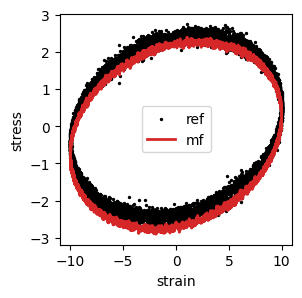

1rads - 100%


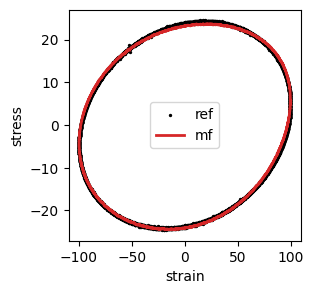

1rads - 1000%


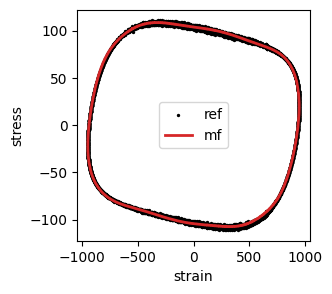

10rads - 10%


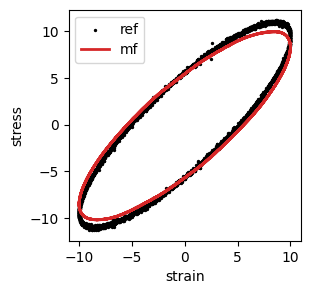

10rads - 100%


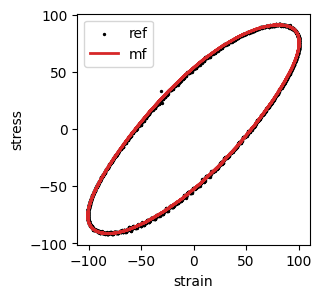

10rads - 1000%


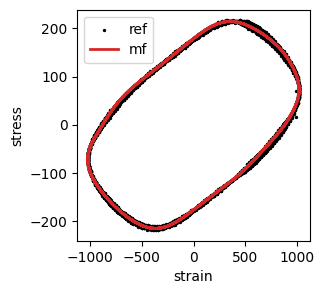

5rads - 50%


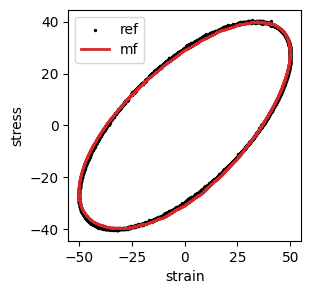

5rads - 500%


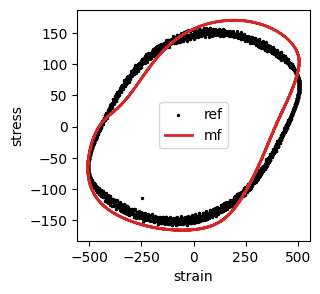

In [21]:
now = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
%store -r
diff = '-'.join([str(int(x)) if x.is_integer() else str(x) for x in diff.flatten()])

with pd.ExcelWriter(now+'_'+diff+".xlsx") as writer:
    for i in range(0, 8):
        t_test, g0_test, w_test, s_test, st_test, sr_test, SN = extractor(i)

        X_test = np.column_stack([st_test, sr_test, w_test])
        y_test = np.column_stack([s_test])

        X_test_norm, y_test_norm = normalize_data(X_test, y_test, *norm)
        y_LF = model_LF(X_test_norm)
        X_MF = np.column_stack((X_test_norm, y_LF))
        y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)
        y_MF_denorm = y_MF * 217.

        fig, ax = plt.subplots(figsize=(3, 3))
        ax.scatter(st_test, y_test, label='ref', color='k', s=2)
        ax.plot(st_test, y_MF_denorm, label='mf', color='tab:red', zorder=10, lw=2)
        plt.xlabel('strain')
        plt.ylabel('stress')
        plt.legend()
        plt.show()
        
        df_exp = np.column_stack([t_test, g0_test, w_test, st_test, sr_test, s_test, y_MF_denorm])
        df_exp = pd.DataFrame(df_exp)
        df_exp.columns = ['Time', 'G0', 'AngFreq', 'Strain', 'StrainRate', 'Stress', 'Stress_pred']
        # df_exp.to_excel(writer, sheet_name=str(SN), index=False)